In [4]:
import zipfile
import shapely
import pyproj
import pandas as pd
from shapely.geometry import shape
import osmnx as ox
import geopandas as gpd
from numpy.linalg import norm
import numpy as np
import math
from matplotlib import pyplot as plt
import contextily as cx
from pyproj.crs import CRS
import scipy

import route2vel
import route2vel.utils as utils
from route2vel.loading import load_graph, compress_edges_dataframe
import route2vel
from notebookutils import display_bounded_shapes

In [5]:
plt.style.use('dark_background')

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
route2vel.load_config('../..')

In [8]:
loc = "Bologna, Emilia Romagna, Italy"

In [9]:
graph = load_graph(loc, allow_merge_different_osmids=False)

Downloaded in 13.37s!
Saved raw copy to d:\Documenti\Universita\tesim\route2vel\resources\graph\Bologna_raw.graphnx.pickle!
Simplifying... (strict=False)
Simplified!
Adding elevation...


100%|██████████| 75/75 [01:39<00:00,  1.32s/it]


Added elevation in 99.24s
Saved to d:\Documenti\Universita\tesim\route2vel\resources\graph\Bologna_nomerge.graphnx.pickle


In [10]:
graph_gdf_nodes, graph_gdf_edges = ox.graph_to_gdfs(graph)

(Nota: la rete stradale usata è di default quella di guida principale, quindi senza strade pedonali o urbane minori)

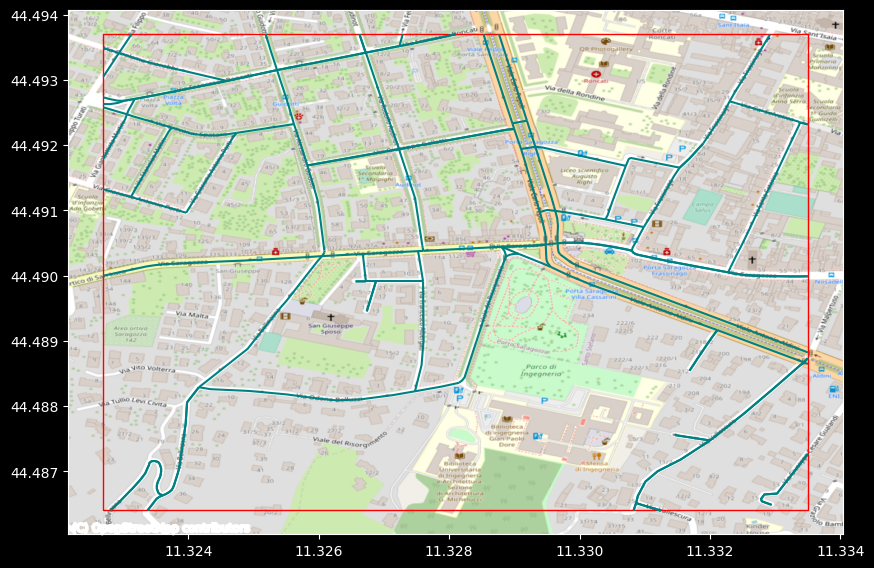

d:\Documenti\Universita\tesim\route2vel\.venv\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


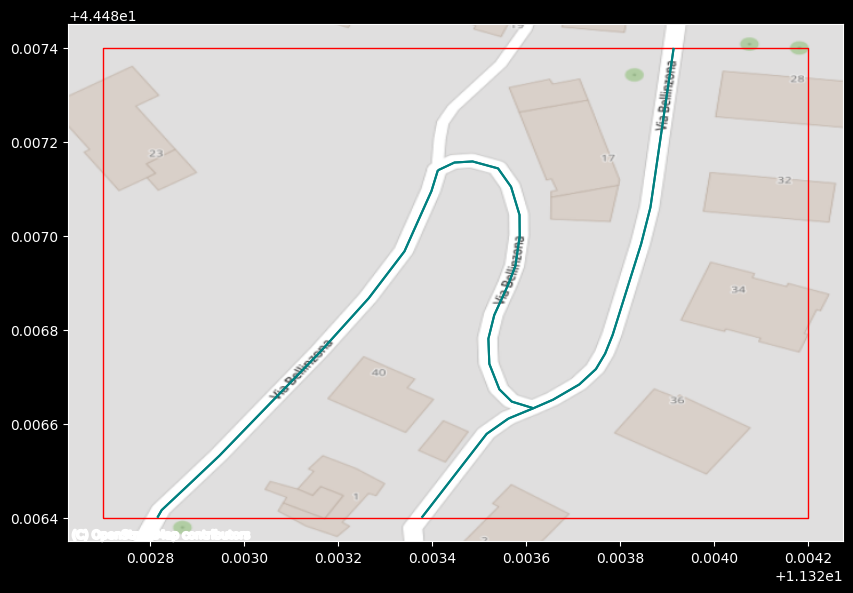

In [11]:
display_bounded_shapes(graph_gdf_edges, (11.3227, 44.4864), (11.3335, 44.4937), crs=graph_gdf_edges.crs)
[sample_roads] = display_bounded_shapes(graph_gdf_edges, (11.3227, 44.4864), (11.3242, 44.4874), crs=graph_gdf_edges.crs);

In [12]:
sample_roads = sample_roads[~sample_roads["reversed"]]
sample_roads

osmid  oneway lanes  ref                name  \
u          v          key                                                      
1825321491 1825321475 0     171528929   False   NaN  NaN  Via Valle Di Preda   
6375292895 6375292915 0     680837436   False   NaN  NaN      Via Bellinzona   
9537220248 1825321491 0     171514618   False   NaN  NaN      Via Bellinzona   
           6375292895 0    1035365081   False   NaN  NaN      Via Bellinzona   
1825321537 9537220248 0     171514618   False   NaN  NaN      Via Bellinzona   

                               highway maxspeed  reversed   length  \
u          v          key                                            
1825321491 1825321475 0    residential       30     False  273.705   
6375292895 6375292915 0    residential       30     False  212.286   
9537220248 1825321491 0    residential       30     False    4.885   
           6375292895 0    residential       30     False   72.475   
1825321537 9537220248 0    residential       30     False  164.929   

                                                                    geometry  \
u          v          key                                                      
1825321491 1825321475 0    LINESTRING (11.32356 44.48661, 11.32352 44.486...   
6375292895 6375292915 0    LINESTRING (11.32341 44.48714, 11.32340 44.487...   
9537220248 1825321491 0    LINESTRING (11.32362 44.48663, 11.32356 44.48661)   
           6375292895 0    LINESTRING (11.32362 44.48663, 11.32357 44.486...   
1825321537 9537220248 0    LINESTRING (11.32391 44.48740, 11.32386 44.487...   

                           grade  grade_abs  speed_kph  travel_time bridge  \
u          v          key                                                    
1825321491 1825321475 0    0.047      0.047       30.0         32.8    NaN   
6375292895 6375292915 0    0.005      0.005       30.0         25.5    NaN   
9537220248 1825321491 0    0.205      0.205       30.0          0.6    NaN   
           6375292895 0    0.055      0.055       30.0          8.7    NaN   
1825321537 9537220248 0    0.121      0.121       30.0         19.8    NaN   

                          access junction tunnel width service  
u          v          key                                       
1825321491 1825321475 0      NaN      NaN    NaN   NaN     NaN  
6375292895 6375292915 0      NaN      NaN    NaN   NaN     NaN  
9537220248 1825321491 0      NaN      NaN    NaN   NaN     NaN  
           6375292895 0      NaN      NaN    NaN   NaN     NaN  
1825321537 9537220248 0      NaN      NaN    NaN   NaN     NaN

To note: even with simplification, there are some edges with duplicate osm ids, as they have a road splitting them.

<Axes: >

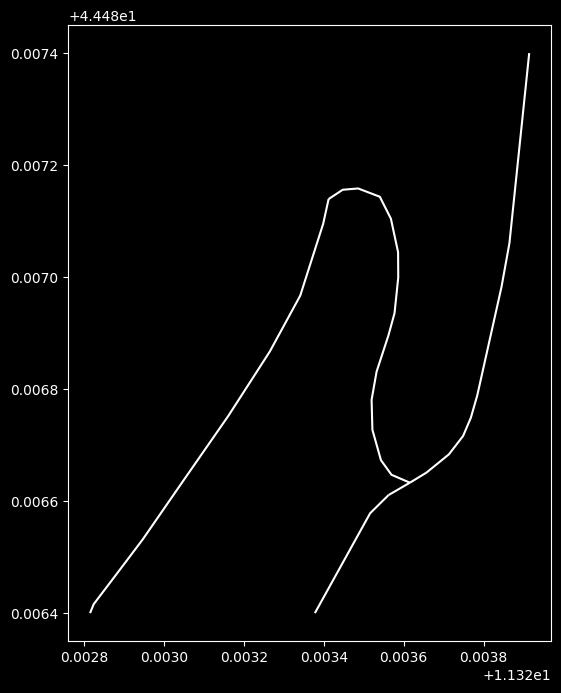

In [13]:
sample_roads.plot(figsize=(8,8))

In [14]:
def interpolate_point_on_bezier(line: shapely.LineString, t: (float|np.ndarray), 
                line_prev: shapely.LineString=None,
                line_next: shapely.LineString=None,
                neighbors_use_size = 1,
                spline_degree=3, transpose_result=True
                ):
    if type(t) != np.ndarray and (t < 0 or t > 1):
        raise ValueError("t should be between 0 and 1.")
    elif type(t) == np.ndarray and np.any((t < 0) | (t > 1)):
        raise ValueError("t should be between 0 and 1.")

    points_list = list(line.coords) if type(line) == shapely.LineString else line
    pstart, pend = 0, len(points_list)
    # Continuous with prev/next street handling
    if line_prev:
        points_list[0:0] = line_prev.coords[:-neighbors_use_size]
        pstart += neighbors_use_size
        pend += neighbors_use_size
        t = (t - 1) / (1 - neighbors_use_size)
    if line_next:
        points_list.extend(line_next.coords[:neighbors_use_size])
        t = t / (1 + neighbors_use_size)

    points = np.array(points_list)
    transposed = points.transpose()

    if len(points) <= spline_degree:
        res = linear_interpolation_polyline(points, t).transpose()
    else:
        tck, u = scipy.interpolate.splprep(transposed, s=0, k=spline_degree)
        res = scipy.interpolate.splev(t, tck)
    if transpose_result:
        return res.transpose()
    else:
        return res
    

def linear_interpolation_polyline(line: shapely.LineString|np.ndarray, t: float|np.ndarray):
    points = list(line.coords) if type(line) == shapely.LineString else line
    n = len(points)
    segment_lengths = np.linalg.norm(points[1:] - points[:-1], axis=1)
    cumulative_lengths = np.cumsum(segment_lengths)
    total_length = np.sum(segment_lengths)
    # Add a leading zero to include all points
    normalized_lengths = np.append(0, cumulative_lengths / total_length)

    indices = np.interp(t, normalized_lengths, np.arange(n))
    lower_indices = np.floor(indices).astype(int)
    upper_indices = np.ceil(indices).astype(int)
    frac = indices - lower_indices

    return (1 - frac)[:, np.newaxis] * points[lower_indices] + frac[:, np.newaxis] * points[upper_indices]

In [27]:
def plot_interpolate_bezier(gdf, points_per_edge = 100, degree = 3, figsize=(12,12)):
    points = []
    colors = []
    for geom in gdf.geometry:
        xs, ys = interpolate_point_on_bezier(geom, np.linspace(0, 1, points_per_edge), transpose_result=False, spline_degree=degree)
        points.append((xs, ys))
        if len(geom.coords) <= degree:
            colors.append('r')
        else:
            colors.append('g')
    print(f"Interpolated {sum(len(edge[0]) for edge in points)} points in {len(sample_roads.geometry)} edges")

    fig, ax = plt.subplots(figsize=figsize)
    gdf.plot(ax=ax, color='k')
    for edge, color in zip(points, colors):
        ax.plot(*edge, color=color)
    cx.add_basemap(ax=ax, crs=gdf.crs, alpha=1, source=cx.providers.OpenStreetMap.Mapnik)
    plt.show()

Interpolated 500 points in 5 edges


d:\Documenti\Universita\tesim\route2vel\.venv\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


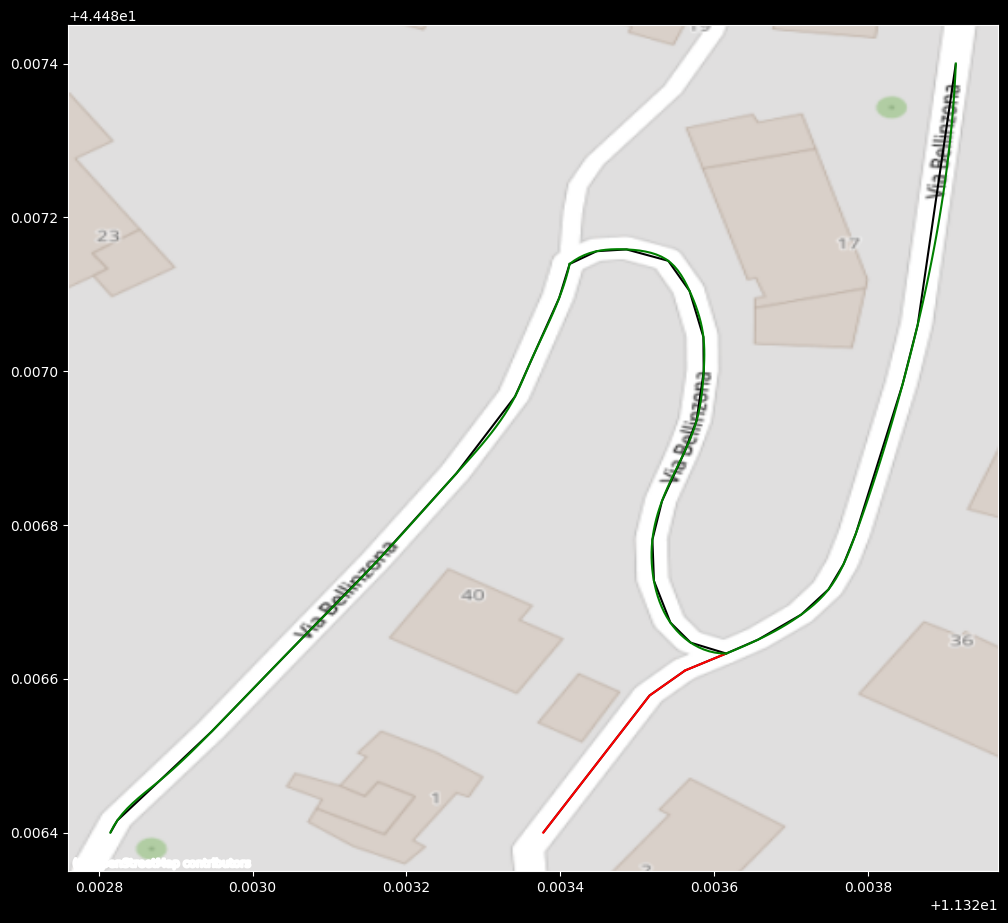

In [28]:
plot_interpolate_bezier(sample_roads, degree = 3)

From this small segment, Bezier curves seem to work very well for curving streets, but the amount of points isn't enough to keep them close to a straight street otherwise. (In red: streets with not enough points to sample a curve). Trying with another degree:

Interpolated 500 points in 5 edges


d:\Documenti\Universita\tesim\route2vel\.venv\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


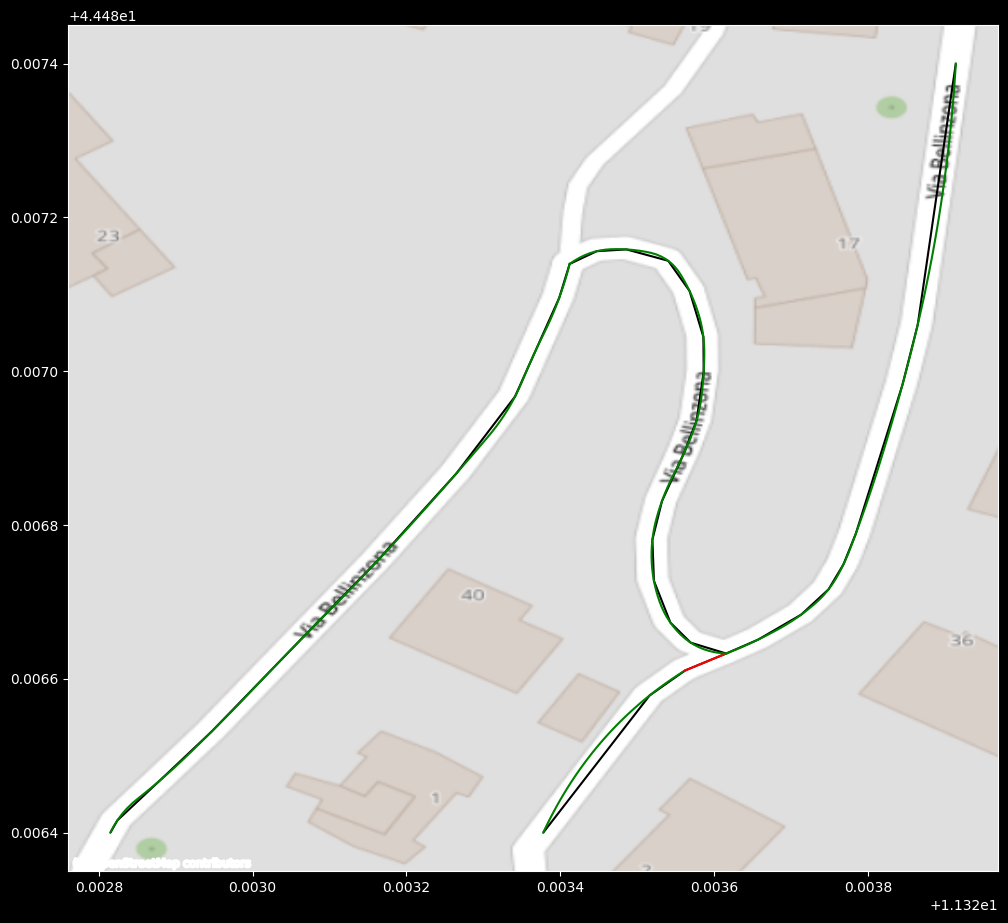

In [29]:
plot_interpolate_bezier(sample_roads, degree = 2)

Now, let's try adding all parts of a Way together for interpolation purposes, to avoid short segments in places where there are crossing to prevent proper bezier interpolation to take place.

Try in a more straight part of road:

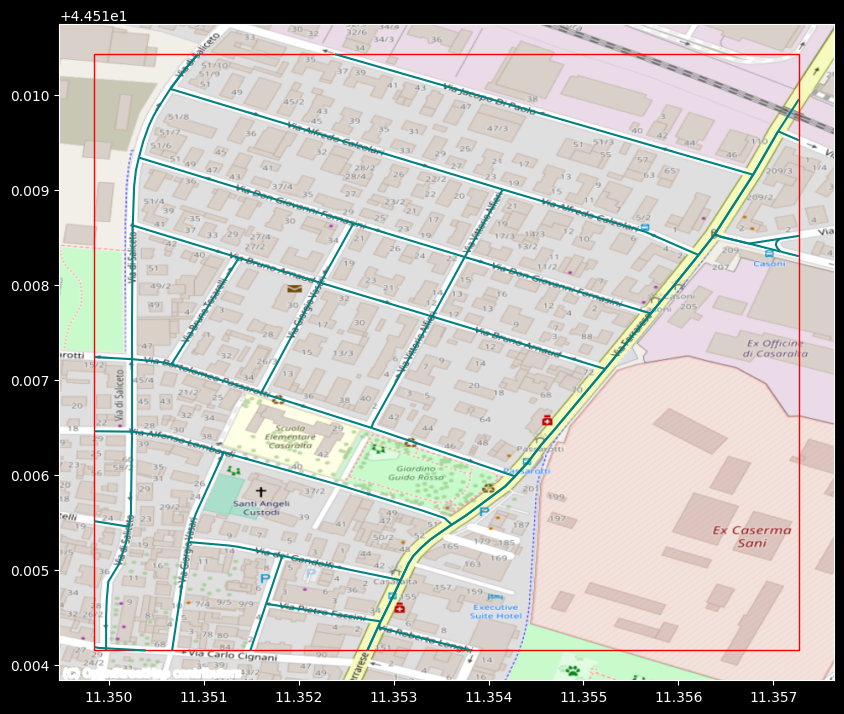

In [18]:
[gdf2] = display_bounded_shapes(graph_gdf_edges, (44.51415,11.34985), (44.52043,11.35727), latLong=True, crs=graph_gdf_edges.crs);

Interpolated 7500 points in 5 edges


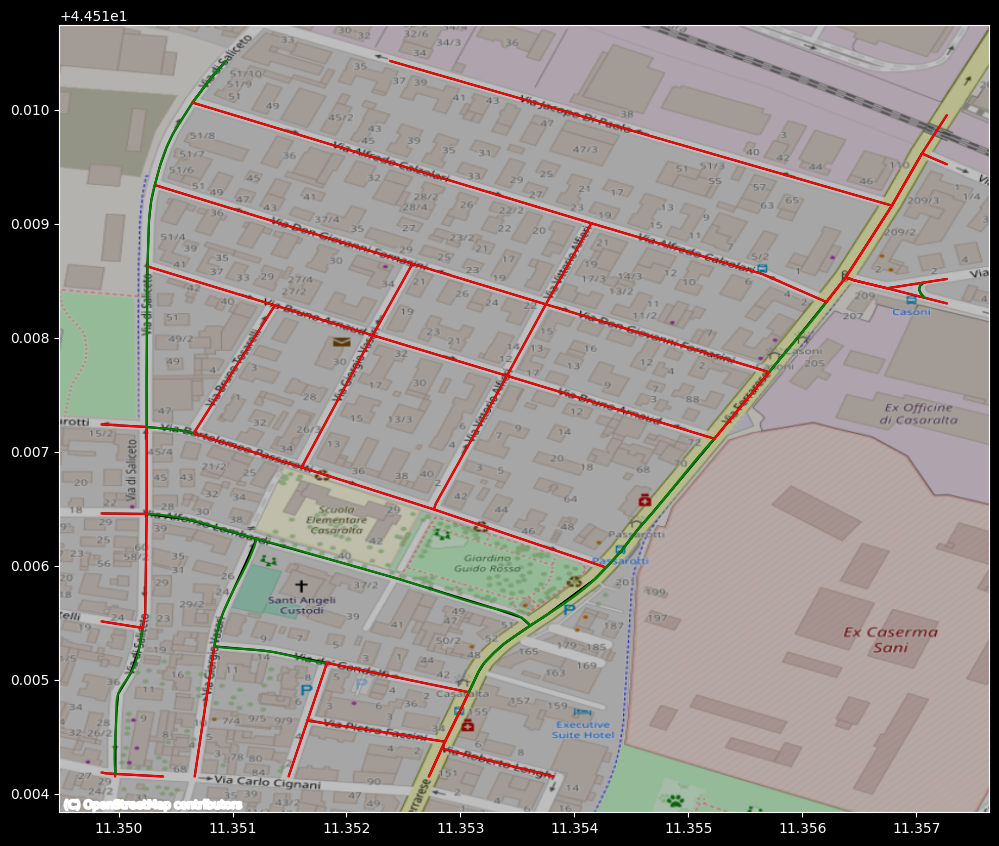

In [19]:
plot_interpolate_bezier(gdf2, degree = 3)

In [20]:
gdf2.geometry.apply(lambda x: len(x.coords)).value_counts()

2    40
3    15
5     8
4     5
7     4
9     2
8     1
Name: count, dtype: int64

Most of the edges here have two vertices, which makes approximation to a bezier curve impossible (which is good, since they are supposed to be straight.) There is still an issue of bezier interpolation failing in places where a continuous way's edge is "interrupted" by crossings. We can try using the previous/next roads for that.

In [21]:
gdf2_compressed = compress_edges_dataframe(gdf2, graph_gdf_nodes, return_geometry=True).reset_index() # note, this compression function isn't finished, and so might lose some street parts

[WARN] Merging geometries, match not found for node at (11.3506657, 44.5141351)
[WARN] Merging geometries, match not found for node at (11.3589735, 44.5187791)
[WARN] Merging geometries, match not found for node at (11.3477276, 44.5158452)
[WARN] Merging geometries, match not found for node at (11.3526694, 44.5140306)
[WARN] Merging geometries, match not found for node at (11.349572, 44.5133553)


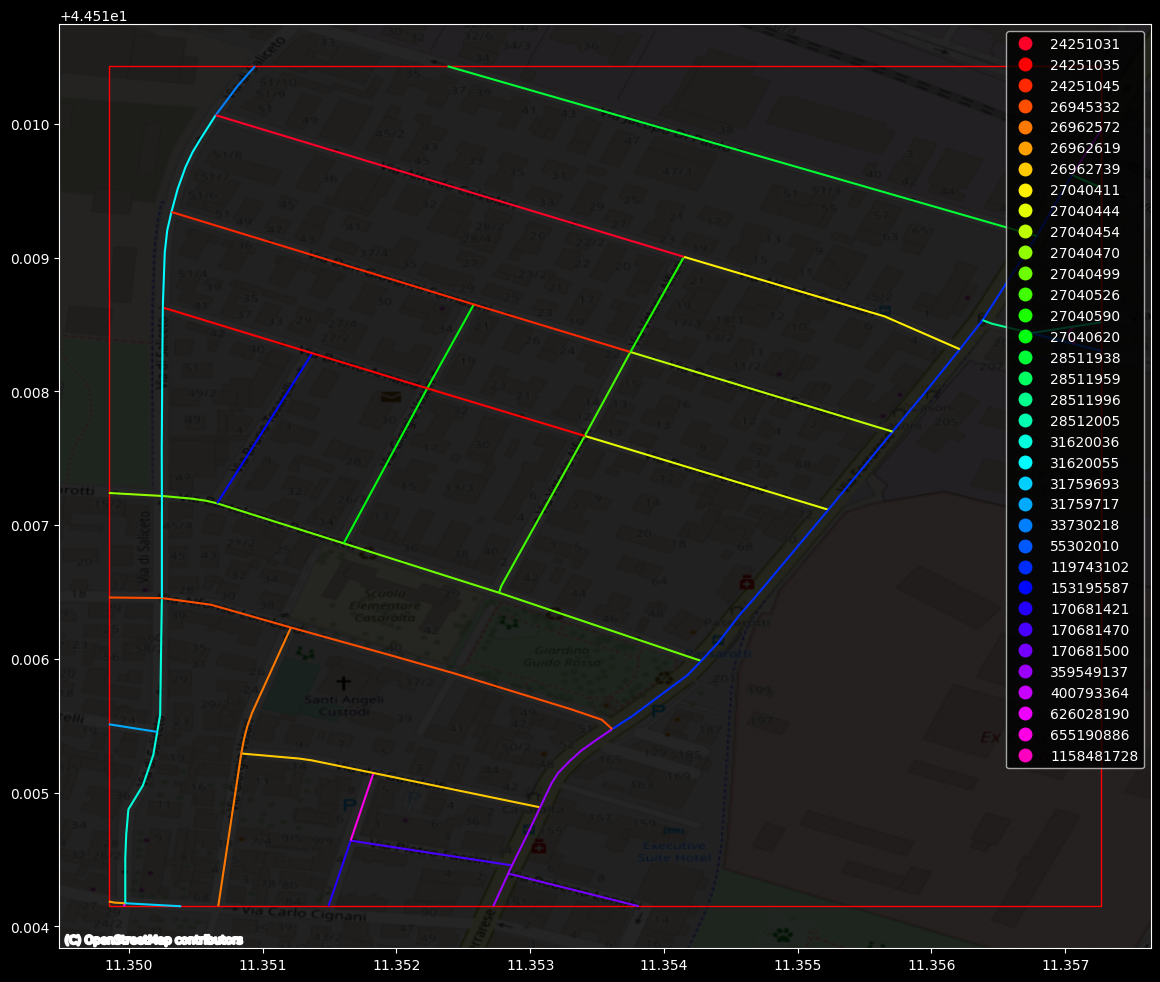

In [22]:
[gdf2_compressed_cropped] = display_bounded_shapes(
    [
        (gdf2_compressed, {'column': 'osmid', 'categorical': True, 'legend': True, 'cmap': 'gist_rainbow'})
    ], 
    (44.51415,11.34985), (44.52043,11.35727), latLong=True, crs=graph_gdf_edges.crs,
    bgalpha=0.15,
    figsize=(30, 12),
);

Interpolated 3500 points in 5 edges


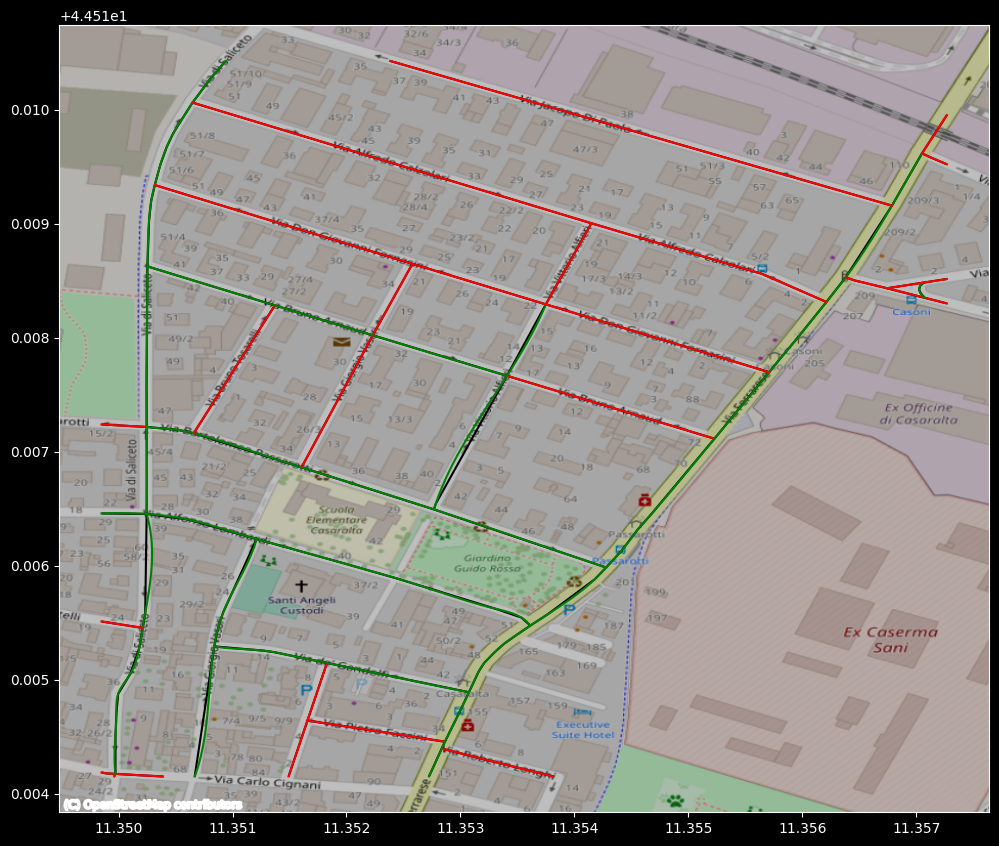

In [23]:
plot_interpolate_bezier(gdf2_compressed_cropped)

There are still issues in some roads; some of them could be offset by merging continuous roads for the purpose of interpolation, which would bring up the issue of detecting such roads.

One last example in a roundabout, to show detail.

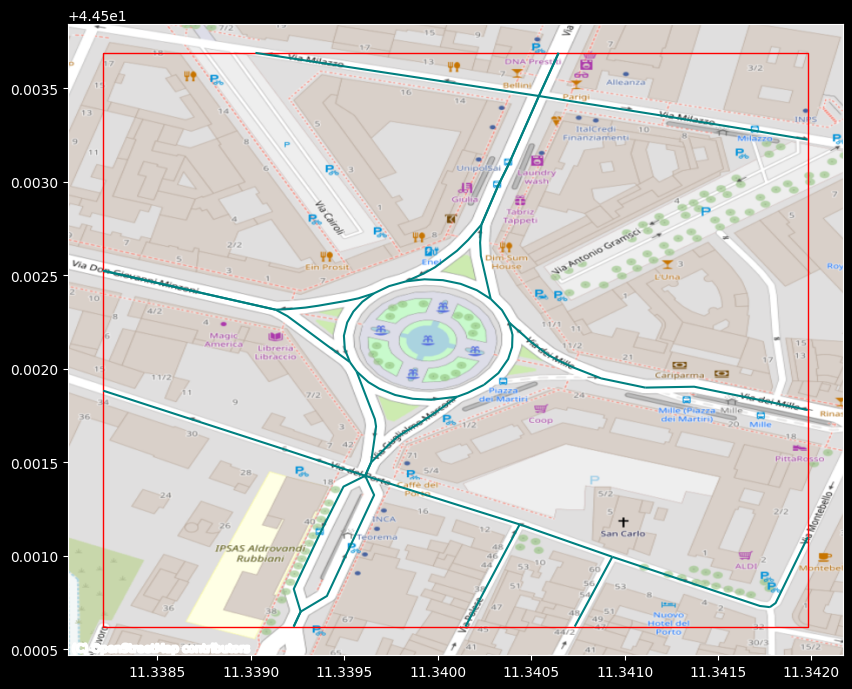

In [24]:
[gdf_roundabout] = display_bounded_shapes(graph_gdf_edges, (44.50369, 11.33821), (44.50062, 11.34198), latLong=True)

Interpolated 57000 points in 5 edges


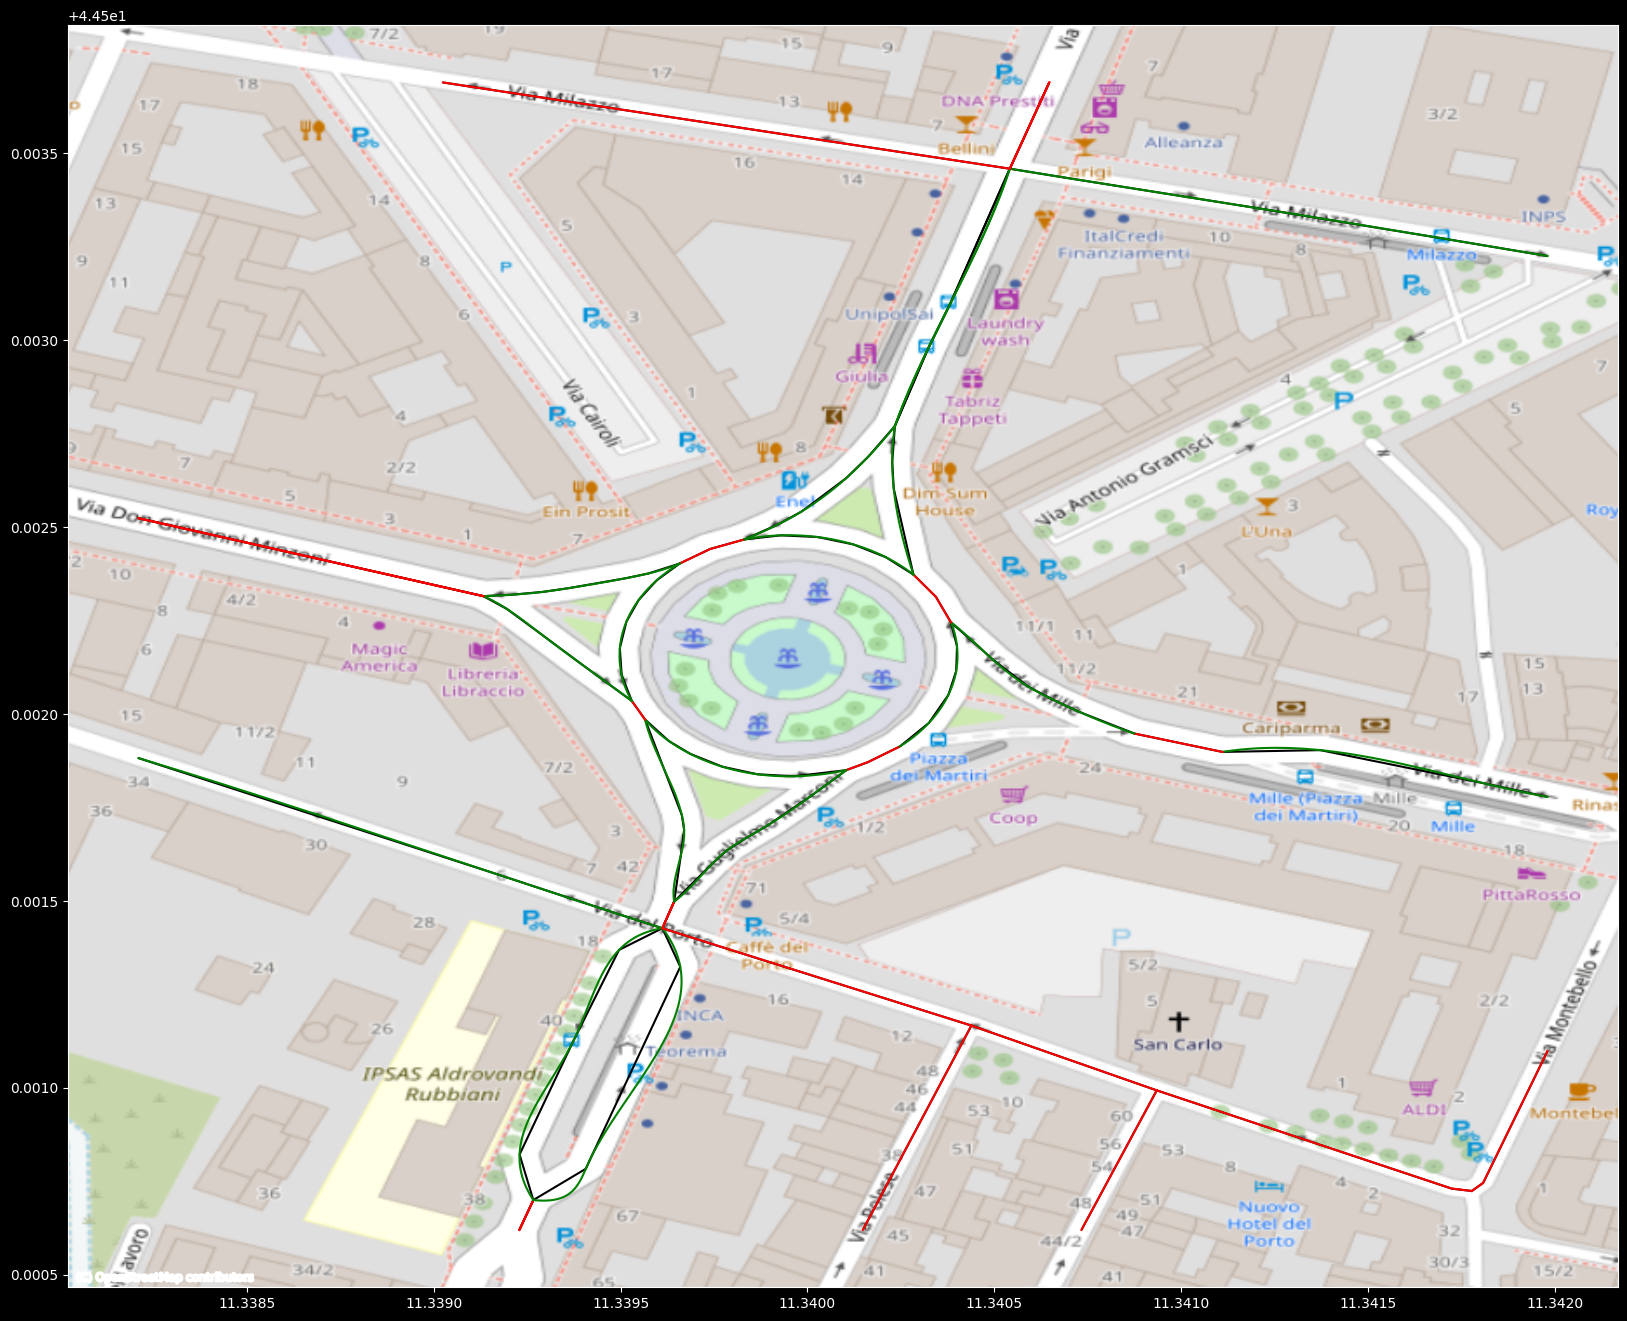

In [31]:
plot_interpolate_bezier(gdf_roundabout, points_per_edge=1500, figsize=(20,20))

We can see very good results on the roundabout, and much worse results below it.